# Prepare custom dataset

In [1]:
# Copyright 2021 wngfra.
# SPDX-License-Identifier: Apache-2.0

import glob
import os
import re
import numpy as np
from bidict import bidict
from numpy.lib.stride_tricks import sliding_window_view
from torch.utils.data import Dataset
from torchvision import transforms

class Texture:
    """ Create a bidict from a texture name list."""

    def __init__(self, texture_names):
        self.texture_by_id = bidict()
        for i, tn in enumerate(set(texture_names)):
            self.texture_by_id[tn] = i

    def get_id(self, texture_name: str):
        return self.texture_by_id[texture_name]

    def get_name(self, texture_id: int):
        return self.texture_by_id.inverse[texture_id]


class TacDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.filelist = [y for x in os.walk(
            root_dir) for y in glob.glob(os.path.join(x[0], '*.csv'))]
        self.params = [(0.0, 0.0)] * len(self.filelist)
        self.texture_names = []
        for i, filename in enumerate(self.filelist):
            basename = os.path.basename(filename)
            namegroups = basename.split('_')

            self.texture_names.append(namegroups[0])
            self.params[i] = [int(re.search(r"\d+", namegroups[1]).group(0)),
                              float(re.search(r"[-+]?\d+", namegroups[2]).group(0))]
        self.textures = Texture(self.texture_names)

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, index):
        filename = self.filelist[index]
        rawdata  = np.genfromtxt(filename, delimiter=',', skip_header=1)
        tacdata  = rawdata[:, 3:]
        texture_name = self.texture_names[index]
        if self.transform:
            tacdata = self.transform(tacdata)
        return tacdata, self.params[index], self.textures.get_id(texture_name)
    
    def count_class(self):
        return len(set(self.texture_names))

    def get_texture_name(self, texture_id):
        return self.textures.get_name(texture_id)

    
""" Custom transforms """

class Normalize(object):
    def __init__(self, axis=0):
        self.axis = axis

    def __call__(self, sample):
        return (sample - np.mean(sample, keepdims=True)) / np.std(sample, keepdims=True)

transform = transforms.Compose([Normalize(axis=1)])
ds = TacDataset('data', transform=transform)

# Iterative PCA

## Methods
1. Resample the time series to the same length and transform into frequency domain
2. Flatten the $Ns \times 16$ frequency matrix into a 1D vector
3. Stack the frequency vectors into a frequency matrix

## Steps
1. Use few samples as a prior knowledge to train a PCA compressor ($Ns \times 16$D $\rightarrow 3$D)
2. For new samples, update the de-meaned frequency matrix
3. Apply iterative PCA to update the compressed frequency vector
4. Try to identify the fabric material under current *pressure* and *speed* settings

In [10]:
import pandas as pd
from numpy.fft import rfft
from scipy import signal

num = 64

def fft_resample(x):
    axis = 0
    
    x = np.asarray(x)
    Nx = x.shape[axis]
    
    X = rfft(x, axis=axis, norm="ortho")
    
    # Placeholder array for output spectrum
    newshape = list(x.shape)
    newshape[0] = num // 2 + 1
    Y = np.zeros(newshape, X.dtype)

    # Copy positive frequency components (and Nyquist, if present)
    N = min(num, Nx)
    nyq = N // 2 + 1  # Slice index that includes Nyquist if present
    sl = [slice(None)] * x.ndim
    sl[axis] = slice(0, nyq)
    Y[tuple(sl)] = X[tuple(sl)]

    # Split/join Nyquist component(s) if present
    # So far we have set Y[+N/2]=X[+N/2]
    if N % 2 == 0:
        if num < Nx:  # downsampling
            sl[axis] = slice(N//2, N//2 + 1)
            Y[tuple(sl)] *= 2.
        elif Nx < num:  # upsampling
            # select the component at frequency +N/2 and halve it
            sl[axis] = slice(N//2, N//2 + 1)
            Y[tuple(sl)] *= 0.5
    
    Ys = np.abs(Y)[1:, :].flatten()
    return Ys

# prepare data
coeff_array = []
labels = []

for i, (sample, param, label) in enumerate(ds):
    coeffs = fft_resample(sample)
    coeff_array.append(coeffs)
    # append label info
    texture, (p, s) = ds.get_texture_name(label), param
    labels.append((texture, label, p, s))

df0 = pd.DataFrame(labels, columns=["texture", "id", "pressure", "speed"])
coeff_array = np.asarray(coeff_array)
coeff_demeaned = coeff_array - np.mean(coeff_array, axis=0) # for simplicity, mean is not iteratively updated

# split textures into (train, test and other) 3 groups
all_fabrics = df0[~df0["texture"].str.contains("Board")]["texture"].unique()
np.random.shuffle(all_fabrics)

tmp = all_fabrics[:len(all_fabrics)//2]
train_id = df0[df0["texture"].isin(tmp)].index
train_label = df0.iloc[train_id]
train_coeff = coeff_demeaned[train_id, :]

tmp = all_fabrics[len(all_fabrics)//2:]
test_id = df0[df0["texture"].isin(tmp)].index
test_label = df0.iloc[test_id]
test_coeff = coeff_demeaned[test_id, :]

tmp = df0[df0["texture"].str.contains("Board")]["texture"].unique()
other_id = df0[df0["texture"].isin(tmp)].index
other_label = df0.iloc[other_id]
other_coeff = coeff_demeaned[other_id, :]

<IPython.core.display.Javascript object>


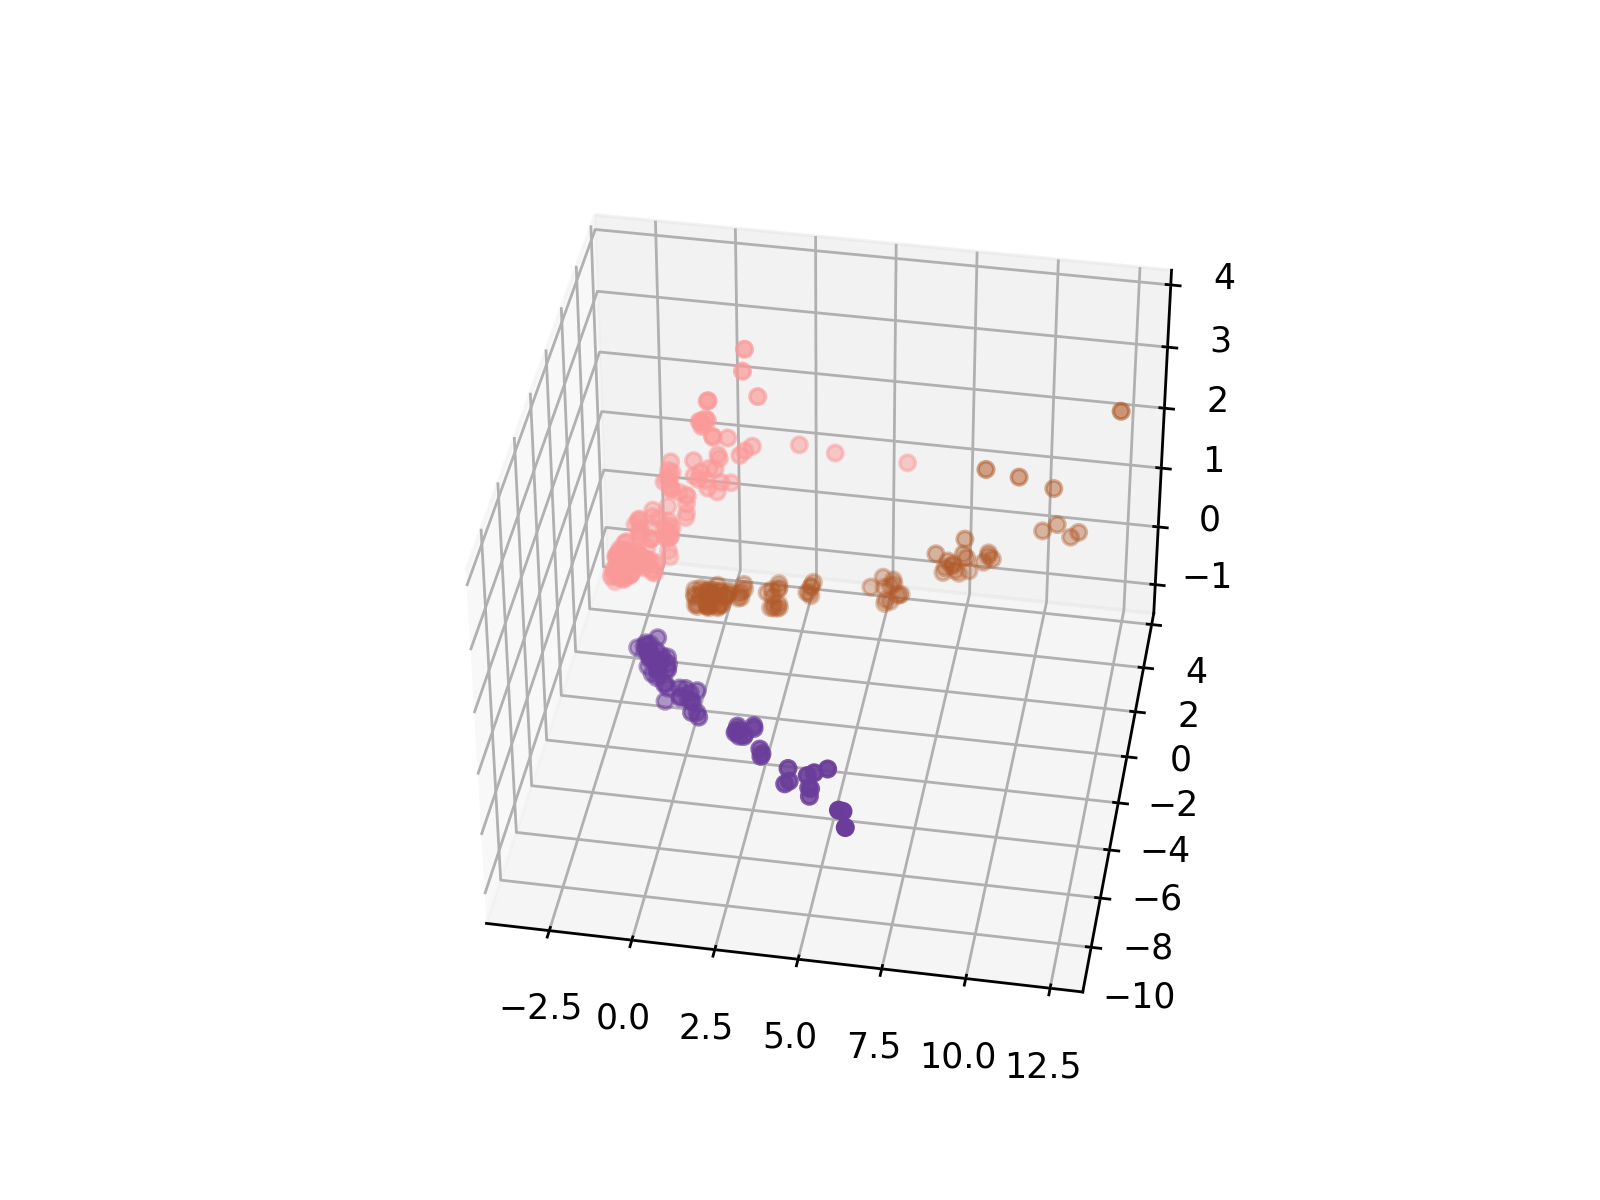

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import KNeighborsClassifier

%matplotlib notebook

textures = df0["texture"].unique()
cmap = plt.cm.get_cmap("Paired", len(textures))
colors = dict([(textures[i], cmap(i)) for i in range(len(textures))])

# prepare a feature extractor(transformer) and classifier
transformer = IncrementalPCA(n_components=3)
classifier = KNeighborsClassifier(n_neighbors=10)

def plot3d(data, labels):
    if len(labels) > 0:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        color = list(map(lambda x: colors[x], labels))
        ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=20, c=color)

def hit_rate(x, y):
    return np.sum(classifier.predict(x) == y) / len(y)

# apply incremental PCA on knowledge base
transformer.partial_fit(train_coeff)
train_3d = transformer.transform(train_coeff)
classifier.fit(train_3d, train_label["id"])
plot3d(train_3d, train_label["texture"])
plt.show()

# Visualization in latent space

<IPython.core.display.Javascript object>


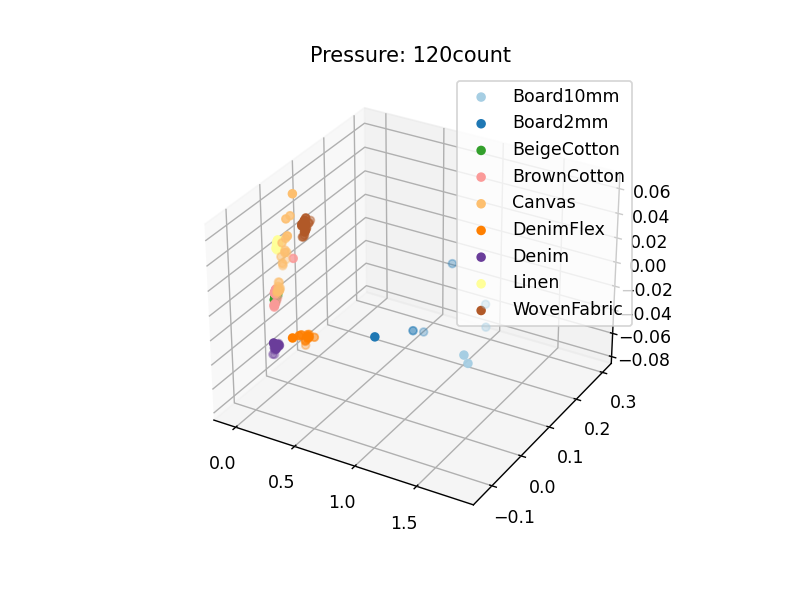

<IPython.core.display.Javascript object>


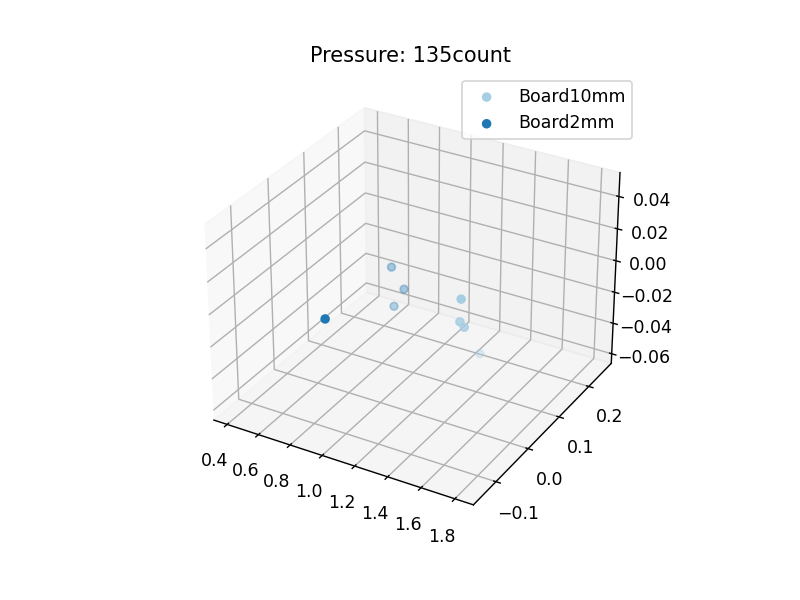

<IPython.core.display.Javascript object>


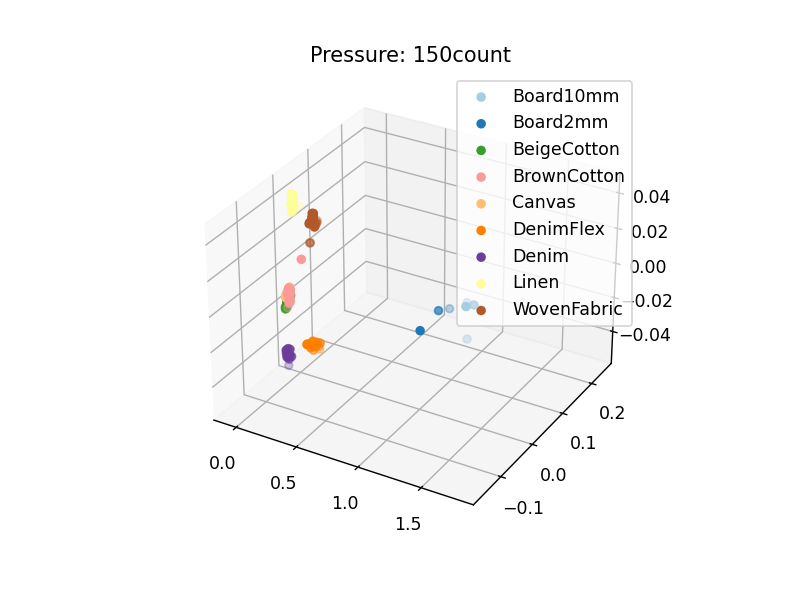

<IPython.core.display.Javascript object>


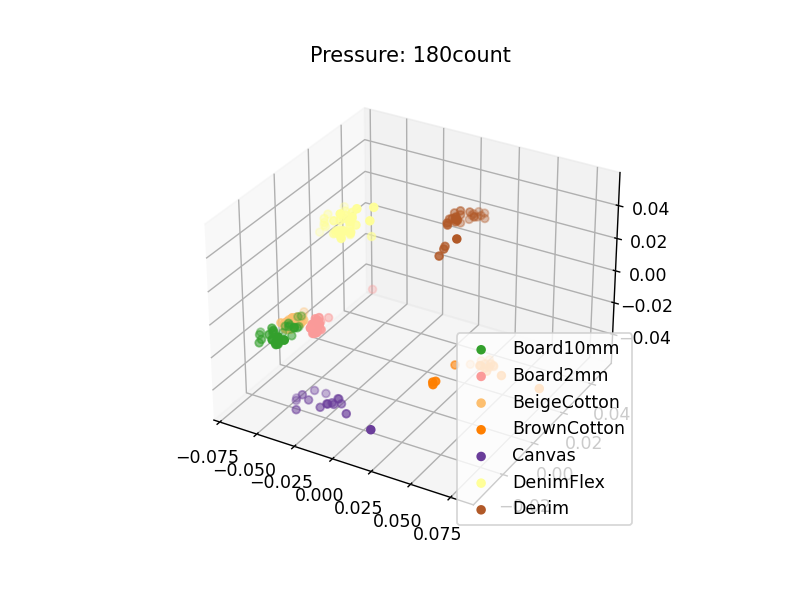

<IPython.core.display.Javascript object>


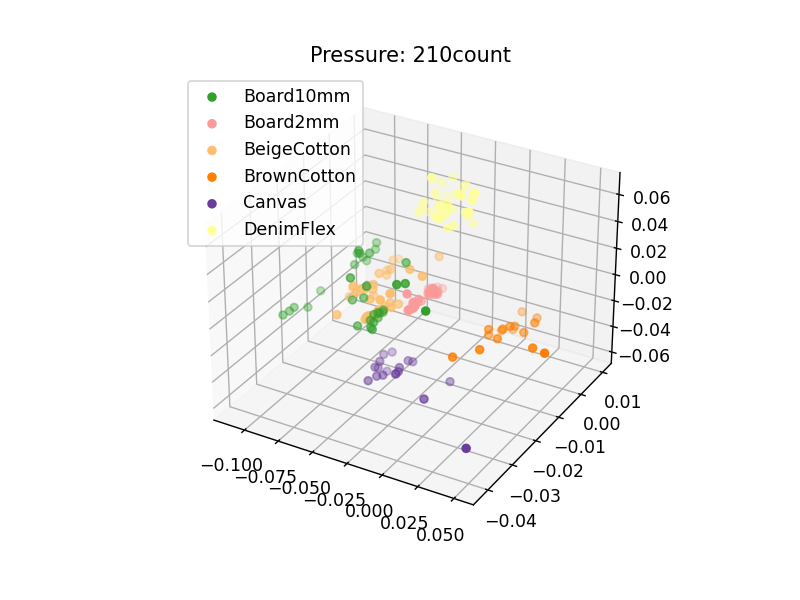

<IPython.core.display.Javascript object>


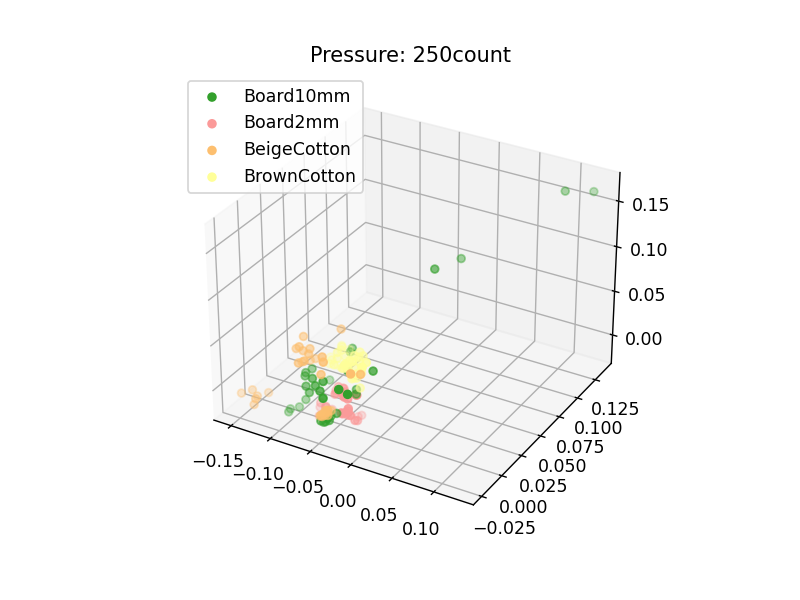

<IPython.core.display.Javascript object>


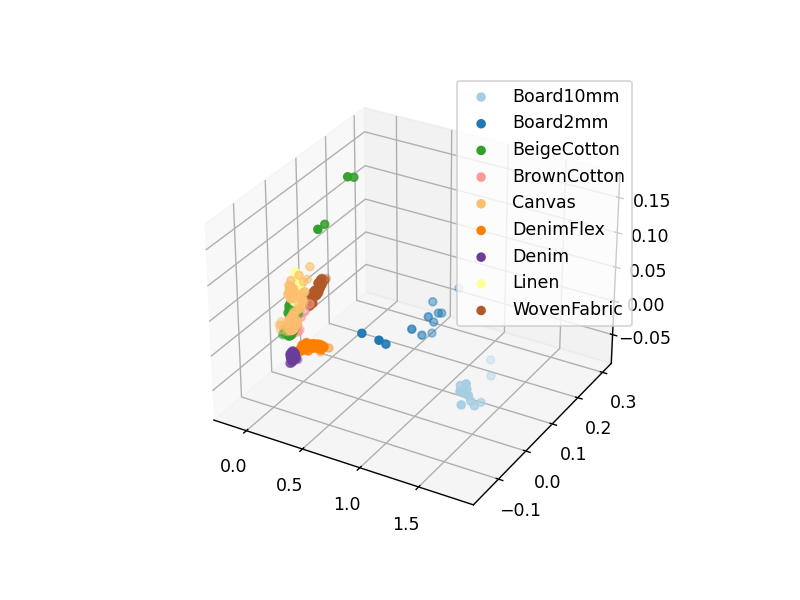

In [178]:
index_array = np.asarray(df0[~df0["texture"].str.contains("Board")].index)
df_ = df.iloc[index_array]

for pressure in df["pressure"].unique():
    X = df_[df_["pressure"] == pressure]
    if len(X) > 0:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        ax.set_title("Pressure: {}count".format(pressure))
        for i, texture in enumerate(textures):
            Y = X[X["texture"] == texture]
            if len(Y) > 0:
                xs, ys, zs = Y["x1"], Y["x2"], Y["x3"]
                ax.scatter(xs, ys, zs, s=20, )
    ax.legend(textures)
    
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for i, texture in enumerate(textures):
    X = df.loc[df["texture"] == texture]
    # plot core vectors
    xs, ys, zs = X["x1"], X["x2"], X["x3"]
    ax.scatter(xs, ys, zs, s=20, c=np.tile(cmap(i), (len(xs), 1)))
ax.legend(textures)
plt.show()

# Construct RNN-AutoEncoder (RAE)

In [184]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence


class Encoder(nn.Module):
    """ Recurent Variational Autoencoder """
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, device, dropout=0.3):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.device = device
        
        self.rnn = nn.GRU(input_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, output_dim)
        self.fc_var = nn.Linear(hidden_dim, output_dim)
        
        self.to(device)
        
    def forward(self, x):
        packed_in = pack_padded_sequence(x[0].to(self.device), x[1].cpu().numpy(), batch_first=True)
        rnn_out, self.hidden = self.rnn(packed_in)
        x_in = self.hidden[-1].squeeze()
        mu = self.fc_mu(x_in)
        var = self.fc_var(x_in)
        
        return mu
    
    def init_hidden(self, batch_dim):
        return (torch.zeros(self.n_layers, batch_dim, self.hidden_dim, device=self.device),
                torch.zeros(self.n_layers, batch_dim, self.hidden_dim, device=self.device))


class RVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, encoding_dim, extra_dim, output_dim, n_layers, device):
        super(RVAE, self).__init__()
        self.device = device
        
        self.encoder = Encoder(input_dim, hidden_dim, encoding_dim, n_layers, device)
        self.classifier = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        encoded = self.encode(x[:2])
        # x_in = torch.hstack([encoded, x[2].to(self.device)])
        y = self.classifier(encoded)

        return y

    def encode(self, x):
        return self.encoder(x)
    
""" Custom collate functions"""

class PadSequence(object):
    def __call__(self, batch):
        # Each element in "batch" is a tuple (data, label).
        # Sort the batch in the descending order
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        # Get each sequence and pad it
        sequences = [torch.tensor(x[0], dtype=torch.float) for x in sorted_batch]
        sequences_padded = pad_sequence(
            sequences, batch_first=True)
        # Store the length of each sequence
        lengths = torch.tensor([len(x) for x in sequences])
        params = torch.tensor(list(map(lambda x: x[1], sorted_batch)), dtype=torch.float)
        labels = torch.tensor(list(map(lambda x: x[2], sorted_batch)))
        return sequences_padded, lengths, params, labels

# Train the network

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import optim
from torch.utils.data import DataLoader

BATCH_SIZE = 8
EPOCHS = 10
INPUT_DIM = 16
NUM_CLASS = ds.count_class()

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

train_loader = DataLoader(ds, batch_size=BATCH_SIZE, collate_fn=PadSequence(), num_workers=6, shuffle=True)
rvae = RVAE(input_dim=INPUT_DIM, hidden_dim=16, encoding_dim=3, extra_dim=2, output_dim=NUM_CLASS, n_layers=3, device=device)
loss_list = []

def train_once(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    output = model(x)
    target = y.to(device)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
    return loss.item()
    
def train_model(data_loader, model):
    optimizer = optim.SGD(model.parameters(), lr = 1e-3)
    criterion = nn.CrossEntropyLoss()
    # loss_list = []
    
    for epoch in range(EPOCHS):
        running_loss = 0.0
        
        for i, (batch, lengths, params, targets) in enumerate(data_loader):
            loss = train_once((batch, lengths, params), targets, model, optimizer, criterion)
            running_loss += loss
            loss_list.append(loss)
            
            if i % 10 == 9:
                print('Epoch {}, {:.2f}% - loss: {:.6f}'.format(epoch + 1, 100.0 * (i + 1.0) / len(data_loader), running_loss / 10))
                running_loss = 0.0
                
    print("Training finished.")
    plt.figure()
    plt.plot(loss_list)
    plt.title("Training Recurrent Autoencoder")
    plt.xlabel("Run")
    plt.ylabel("Loss")
    plt.show()
    
train_model(train_loader, rvae)